In [4]:
import xarray as xr
from pathlib import Path
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import patches

import functions.eddy_feedback as ef
import functions.data_wrangling as data

# Data wrangling

### Import data

In [5]:
path = '/home/links/ct715/data_storage/isca/held-suarez'
exp_list = ['HS_T42_100y_60delh-nc', 'HS_T85_100y_60delh-nc']
# exp_list = ['HS_T42_100y_60delh-nc']

datasets = {}
for exp in exp_list:
    
    nc_path = Path(path) / exp
    nc_files = list(nc_path.glob('*.nc'))
    
    ds = xr.open_mfdataset(
        nc_files,
        parallel=True,
        chunks={'time': 360}
    )

    datasets[exp] = ds

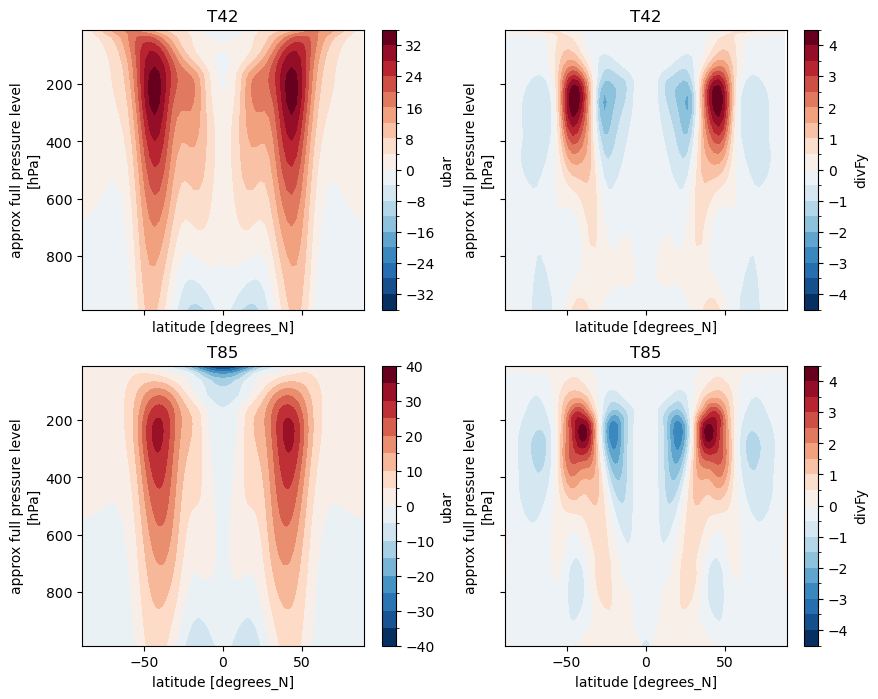

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8), sharey=True, sharex=True)
# colour_bar = np.linspace(-5e-5, 5e-5, 21)

datasets['HS_T42_100y_60delh-nc'].mean('time').ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0,0])
datasets['HS_T42_100y_60delh-nc'].mean('time').divFy.plot.contourf(levels=20, yincrease=False, ax=axes[0,1])

datasets['HS_T85_100y_60delh-nc'].mean('time').ubar.plot.contourf(levels=20, yincrease=False, ax=axes[1,0])
datasets['HS_T85_100y_60delh-nc'].mean('time').divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1,1])

for ax in axes[0,:]:
    ax.set_title('T42')
for ax in axes[1,:]:
    ax.set_title('T85')

### Subsetting and calculations

In [7]:
# calculate EFP for each experiment and save to dictionary
efp_values = {}
for exp in exp_list:
    
    # calculate EFP
    efp_NH = ef.calculate_efp(datasets[exp], data_type='isca')
    efp_SH = ef.calculate_efp(datasets[exp], data_type='isca', calc_south_hemis=True)
    
    # save value into a dict of dictionaries 
    efp_values[exp] = {
        'NH': efp_NH,
        'SH': efp_SH
    }
efp_values

{'HS_T42_100y_60delh-nc': {'NH': 0.134, 'SH': 0.1294},
 'HS_T85_100y_60delh-nc': {'NH': 0.019, 'SH': 0.0202}}

In [8]:
# calculate djf seasonal mean
exps_djf = {}
exps_jas = {}
for exp in exp_list:
    
    # calc seasonal mean for each dataset
    djf_mean = data.seasonal_mean(datasets[exp], season='djf')
    # save to dict
    exps_djf[exp] = djf_mean
    
    # calc seasonal mean for each dataset
    jas_mean = data.seasonal_mean(datasets[exp], season='jas')
    # save to dict
    exps_jas[exp] = jas_mean

### Annual differences

In [9]:
datasets['HS_T85_100y_60delh-nc'] = datasets['HS_T85_100y_60delh-nc'].interp(lat=datasets['HS_T42_100y_60delh-nc'].lat.values)

diff = datasets['HS_T85_100y_60delh-nc'].mean('time') - datasets['HS_T42_100y_60delh-nc'].mean('time')

# # subset data
diff = diff.sel(lat=slice(-85,85))
diff = diff.sel(level=slice(925., 100))

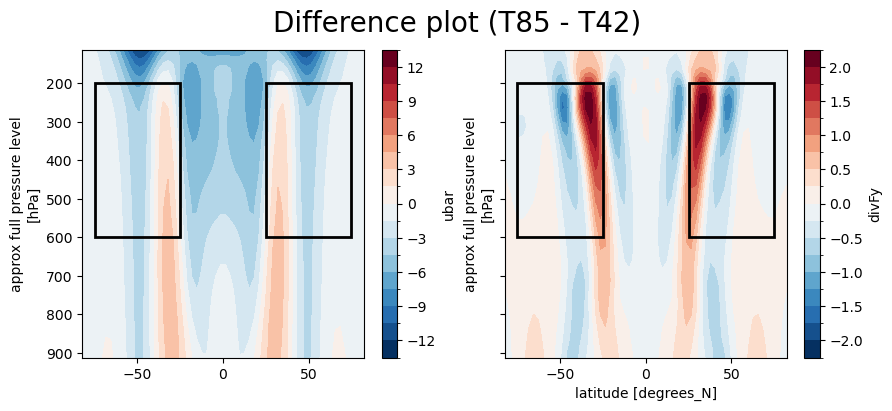

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
# colour_bar = np.linspace(-5e-5, 5e-5, 21)

diff.ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0])
diff.divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1])

# set titles
axes[0].set_title(f'', fontsize=16)
axes[1].set_title('')

# set axes titles
axes[0].set_xlabel('')

# plot rectangle
# Define rectangles and add them to each subplot
for ax in axes[:]:
    rect = patches.Rectangle((-75, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
for ax in axes[:]:
    rect = patches.Rectangle((25, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
    

fig.suptitle('Difference plot (T85 - T42)', fontsize=20)

plt.show()